In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 거리 계산
import math
from geopy.distance import geodesic
import geopy.distance

# 데이터 전처리
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

# 데이터 분할
from sklearn.model_selection import train_test_split

# 학습 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# 성능평가
from sklearn.model_selection import cross_val_score

## 데이터 읽기

In [2]:
df_train = pd.read_csv('./datasets/train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

## 아주 기본적인 전처리
- 오브젝트 없애기

In [4]:
# 시내/시외 맵핑
mapping_dict = {'시내': 0, '시외': 1}

df_train['in_out'] = df_train['in_out'].map(mapping_dict)

In [5]:
df_station = df_train[['station_code', 'station_name']]

df_train.drop('station_name', axis=1, inplace=True)

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day

In [7]:
df_train.drop('date', axis=1, inplace=True)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   bus_route_id   415423 non-null  int64  
 2   in_out         415423 non-null  int64  
 3   station_code   415423 non-null  int64  
 4   latitude       415423 non-null  float64
 5   longitude      415423 non-null  float64
 6   6~7_ride       415423 non-null  float64
 7   7~8_ride       415423 non-null  float64
 8   8~9_ride       415423 non-null  float64
 9   9~10_ride      415423 non-null  float64
 10  10~11_ride     415423 non-null  float64
 11  11~12_ride     415423 non-null  float64
 12  6~7_takeoff    415423 non-null  float64
 13  7~8_takeoff    415423 non-null  float64
 14  8~9_takeoff    415423 non-null  float64
 15  9~10_takeoff   415423 non-null  float64
 16  10~11_takeoff  415423 non-null  float64
 17  11~12_takeoff  415423 non-nul

In [9]:
df_train.corrwith(df_train['18~20_ride']).sort_values(ascending=False)

18~20_ride       1.000000
11~12_ride       0.569747
10~11_ride       0.512666
9~10_ride        0.494085
8~9_ride         0.445316
7~8_ride         0.371751
11~12_takeoff    0.313540
9~10_takeoff     0.295875
10~11_takeoff    0.290691
8~9_takeoff      0.274360
6~7_ride         0.262173
7~8_takeoff      0.219430
6~7_takeoff      0.178353
latitude         0.079261
station_code     0.034360
in_out           0.022116
day              0.004882
id              -0.000544
longitude       -0.021368
bus_route_id    -0.143702
year                  NaN
month                 NaN
dtype: float64

In [10]:
# 승차인원 및 하차인원 총계 column 추가
df_train['ride_sum'] = df_train['6~7_ride'] + df_train['7~8_ride'] + df_train['8~9_ride'] + df_train['9~10_ride'] + df_train['10~11_ride'] + df_train['11~12_ride']
df_train['takeoff_sum'] = df_train['6~7_takeoff'] + df_train['7~8_takeoff'] + df_train['8~9_takeoff'] + df_train['9~10_takeoff'] + df_train['10~11_takeoff'] + df_train['11~12_takeoff']

In [11]:
df_train.corrwith(df_train['18~20_ride']).sort_values(ascending=False)

18~20_ride       1.000000
ride_sum         0.621556
11~12_ride       0.569747
10~11_ride       0.512666
9~10_ride        0.494085
8~9_ride         0.445316
takeoff_sum      0.383496
7~8_ride         0.371751
11~12_takeoff    0.313540
9~10_takeoff     0.295875
10~11_takeoff    0.290691
8~9_takeoff      0.274360
6~7_ride         0.262173
7~8_takeoff      0.219430
6~7_takeoff      0.178353
latitude         0.079261
station_code     0.034360
in_out           0.022116
day              0.004882
id              -0.000544
longitude       -0.021368
bus_route_id    -0.143702
year                  NaN
month                 NaN
dtype: float64

## 인구 데이터 전처리

In [12]:
df_pop = pd.read_csv('./datasets/jeju dong and geomtry.csv')
#인구 데이터

In [13]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       43 non-null     object 
 1   Sep_pop    43 non-null     object 
 2   Oct_pop    43 non-null     object 
 3   latitude   43 non-null     float64
 4   longitude  43 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.8+ KB


In [14]:
#인포 데이터 처리
# 오브젝트가 있어서 처리하기 위함.
df_pop.replace(',', '',regex=True, inplace=True) #인구에 ,가 있어 지움

In [15]:
df_pop = df_pop.astype({'Sep_pop' :'int', 'Oct_pop' : 'int'})
# 인구 숫자형으로 바꾸기

In [16]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       43 non-null     object 
 1   Sep_pop    43 non-null     int64  
 2   Oct_pop    43 non-null     int64  
 3   latitude   43 non-null     float64
 4   longitude  43 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.8+ KB


### 위경도 데이터 전처리 

In [17]:
# 스테이션 코드의 위경도 받기
t1 = list(df_train.loc[:,['latitude', 'longitude']].groupby(df_train['station_code']))

In [18]:
df_pop.head()

,Name,Sep_pop,Oct_pop,latitude,longitude
0,한림읍,25084,25110,33.376347,126.284734
1,애월읍,37194,37247,33.411040,126.393958
2,구좌읍,16323,16274,33.498076,126.795431
3,조천읍,25114,25155,33.472170,126.667445
4,한경면,9423,9432,33.322497,126.223161


In [19]:
sample=[] # 빈 리스트 
sample2 = [] # 빈리스트2
for i in range(len(t1)): #3563 반복
    sample=[] #매번 반복되면 데이터가 쌓여서 리셋함.
    for j in range(len(df_pop)): # 43 반복
        t1_latlong = t1[i][1].iloc[0][0], t1[i][1].iloc[0][1] # 스테이션 코드의 좌표
        t2_latlong = df_pop.iloc[j][3], df_pop.iloc[j][4] #행정동의 좌표
        sample.append(geopy.distance.geodesic(t1_latlong, t2_latlong).km) # 둘의 거리 계산
    sample2.append([t1[i][0], df_pop.loc[sample.index(min(sample))][1], min(sample)]) 
    # 스테이션코드, 9월 인구, 거리

In [20]:
df_sample2 = pd.DataFrame(sample2) #sample2의 df화

In [21]:
df_sample2.columns = ['station_code', 'Population', 'distance']
# 칼럼추가

In [22]:
df_train_new = pd.merge(df_train, df_sample2)
# 스테이션 코드를 키값으로 인구를 추가시킴

In [23]:
df_train_new.T

,0,1,2,3,4,5,6,7,8,9,...,415413,415414,415415,415416,415417,415418,415419,415420,415421,415422
id,0.000000e+00,1.153800e+04,2.649800e+04,4.198300e+04,5.672200e+04,7.242800e+04,8.778000e+04,9.797800e+04,1.095600e+05,1.248570e+05,...,3.590150e+05,3.649330e+05,4.060810e+05,3.658450e+05,3.742840e+05,3.742910e+05,3.935240e+05,3.979210e+05,4.004330e+05,4.066620e+05
bus_route_id,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,...,2.181000e+07,2.606000e+07,2.606000e+07,2.754000e+07,2.001000e+07,2.001000e+07,2.788000e+07,3.158000e+07,2.221000e+07,2.718000e+07
in_out,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
station_code,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,...,1.604000e+03,1.891000e+03,1.891000e+03,4.252000e+03,6.115010e+06,6.115044e+06,1.368000e+03,3.576000e+03,1.585000e+03,3.552000e+03
latitude,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,...,3.336258e+01,3.328732e+01,3.328732e+01,3.328134e+01,3.395033e+01,3.396252e+01,3.333595e+01,3.325899e+01,3.343489e+01,3.354574e+01
longitude,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,...,1.262472e+02,1.266069e+02,1.266069e+02,1.262719e+02,1.263069e+02,1.262943e+02,1.262633e+02,1.262755e+02,1.267324e+02,1.268037e+02
6~7_ride,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7~8_ride,1.000000e+00,8.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
8~9_ride,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,8.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9~10_ride,5.000000e+00,3.000000e+00,7.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00


In [24]:
df_train_new.corrwith(df_train_new['18~20_ride']).sort_values(ascending=False)

18~20_ride       1.000000
ride_sum         0.621556
11~12_ride       0.569747
10~11_ride       0.512666
9~10_ride        0.494085
8~9_ride         0.445316
takeoff_sum      0.383496
7~8_ride         0.371751
11~12_takeoff    0.313540
9~10_takeoff     0.295875
10~11_takeoff    0.290691
8~9_takeoff      0.274360
6~7_ride         0.262173
7~8_takeoff      0.219430
6~7_takeoff      0.178353
latitude         0.079261
station_code     0.034360
in_out           0.022116
day              0.004882
Population       0.000433
id              -0.000544
longitude       -0.021368
distance        -0.087756
bus_route_id    -0.143702
year                  NaN
month                 NaN
dtype: float64

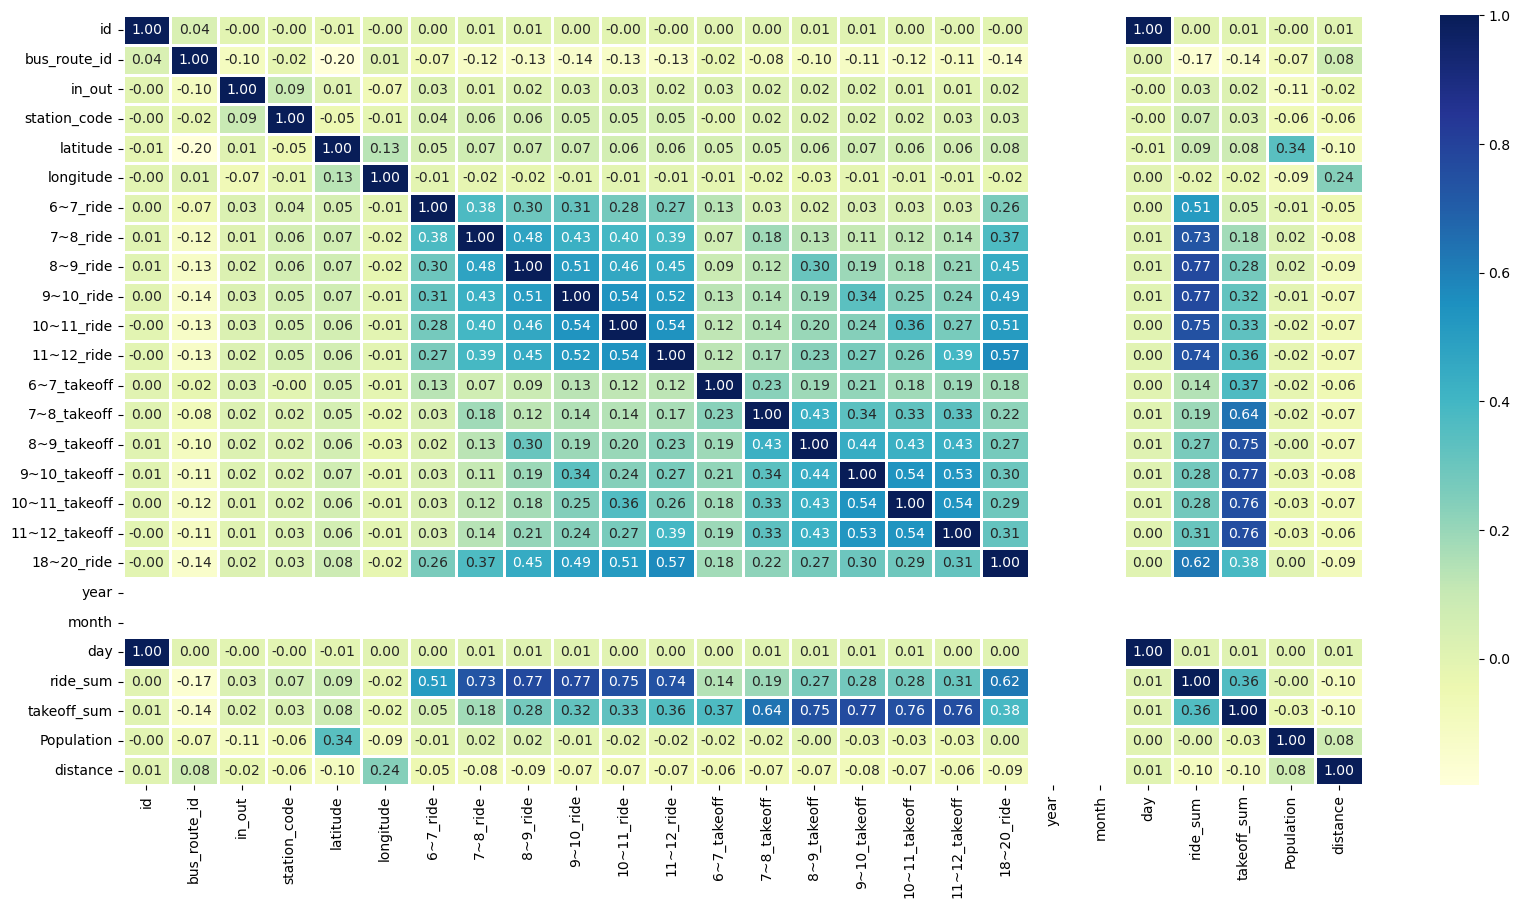

In [25]:
plt.figure(figsize=(20, 10))

sns.heatmap(data=df_train_new.corr(), annot=True, fmt='.2f', cmap='YlGnBu', linewidth=1.0)
plt.show()

In [26]:
df_train_new

,id,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,...,10~11_takeoff,11~12_takeoff,18~20_ride,year,month,day,ride_sum,takeoff_sum,Population,distance
0,0,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,5.0,...,0.0,0.0,0.0,2019,9,1,16.0,0.0,15515,1.759087
1,11538,4270000,1,344,33.48990,126.49373,1.0,8.0,3.0,3.0,...,0.0,0.0,1.0,2019,9,2,19.0,0.0,15515,1.759087
2,26498,4270000,1,344,33.48990,126.49373,2.0,4.0,2.0,7.0,...,0.0,0.0,0.0,2019,9,3,19.0,0.0,15515,1.759087
3,41983,4270000,1,344,33.48990,126.49373,3.0,3.0,1.0,2.0,...,0.0,0.0,0.0,2019,9,4,17.0,0.0,15515,1.759087
4,56722,4270000,1,344,33.48990,126.49373,2.0,4.0,8.0,0.0,...,0.0,0.0,3.0,2019,9,5,21.0,0.0,15515,1.759087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,374291,20010000,1,6115044,33.96252,126.29429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2019,9,28,1.0,0.0,2079,3.138950
415419,393524,27880000,0,1368,33.33595,126.26332,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2019,9,29,0.0,1.0,9423,4.025707
415420,397921,31580000,0,3576,33.25899,126.27554,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2019,9,29,1.0,1.0,23162,2.671149
415421,400433,22210000,0,1585,33.43489,126.73242,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2019,9,30,1.0,0.0,25114,7.320437


In [27]:
df_train_new['route by station'] = df_train['bus_route_id'] * df_train['station_code']

In [28]:
df_train_new['route by station'] = df_train_new['route by station']/1000

In [29]:
df_train_new

,id,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,...,11~12_takeoff,18~20_ride,year,month,day,ride_sum,takeoff_sum,Population,distance,route by station
0,0,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,5.0,...,0.0,0.0,2019,9,1,16.0,0.0,15515,1.759087,1.468880e+06
1,11538,4270000,1,344,33.48990,126.49373,1.0,8.0,3.0,3.0,...,0.0,1.0,2019,9,2,19.0,0.0,15515,1.759087,1.524390e+06
2,26498,4270000,1,344,33.48990,126.49373,2.0,4.0,2.0,7.0,...,0.0,0.0,2019,9,3,19.0,0.0,15515,1.759087,1.844640e+06
3,41983,4270000,1,344,33.48990,126.49373,3.0,3.0,1.0,2.0,...,0.0,0.0,2019,9,4,17.0,0.0,15515,1.759087,6.742330e+06
4,56722,4270000,1,344,33.48990,126.49373,2.0,4.0,8.0,0.0,...,0.0,3.0,2019,9,5,21.0,0.0,15515,1.759087,7.028420e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,374291,20010000,1,6115044,33.96252,126.29429,0.0,0.0,0.0,0.0,...,0.0,0.0,2019,9,28,1.0,0.0,2079,3.138950,3.705378e+07
415419,393524,27880000,0,1368,33.33595,126.26332,0.0,0.0,0.0,0.0,...,0.0,0.0,2019,9,29,0.0,1.0,9423,4.025707,5.133048e+07
415420,397921,31580000,0,3576,33.25899,126.27554,0.0,0.0,0.0,1.0,...,0.0,0.0,2019,9,29,1.0,1.0,23162,2.671149,7.620804e+07
415421,400433,22210000,0,1585,33.43489,126.73242,0.0,1.0,0.0,0.0,...,0.0,0.0,2019,9,30,1.0,0.0,25114,7.320437,1.080106e+08


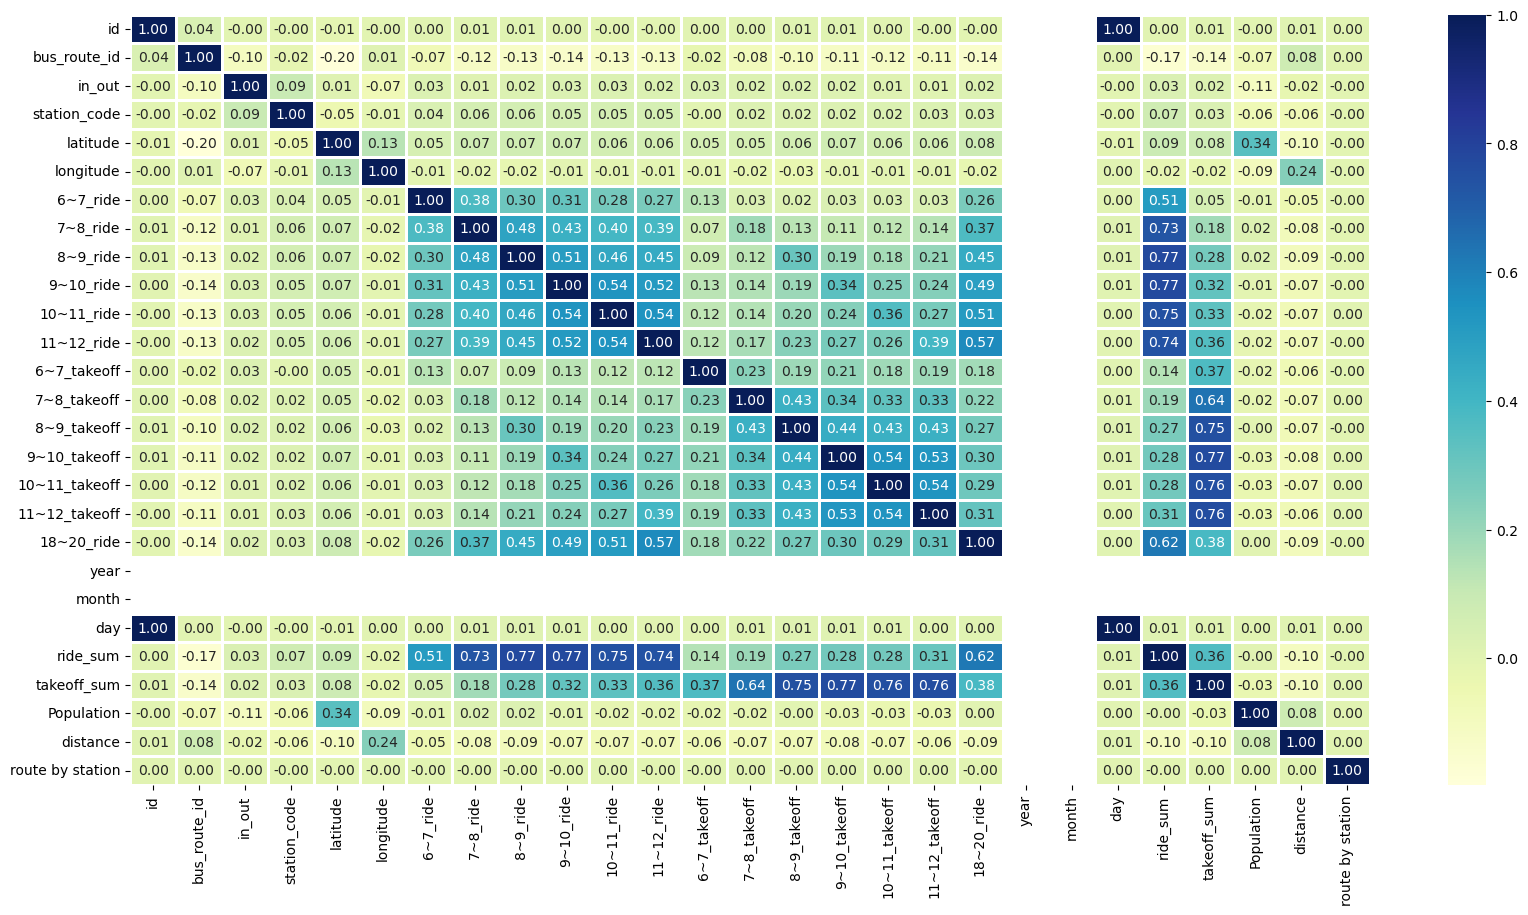

In [30]:
plt.figure(figsize=(20, 10))

sns.heatmap(data=df_train_new.corr(), annot=True, fmt='.2f', cmap='YlGnBu', linewidth=1.0)
plt.show()

# 수치형 데이터 스케일링

In [31]:
X = df_train_new.drop('18~20_ride', axis=1)
y = df_train_new['18~20_ride']

In [32]:
X.T

,0,1,2,3,4,5,6,7,8,9,...,415413,415414,415415,415416,415417,415418,415419,415420,415421,415422
id,0.000000e+00,1.153800e+04,2.649800e+04,4.198300e+04,5.672200e+04,7.242800e+04,8.778000e+04,9.797800e+04,1.095600e+05,1.248570e+05,...,3.590150e+05,3.649330e+05,4.060810e+05,3.658450e+05,3.742840e+05,3.742910e+05,3.935240e+05,3.979210e+05,4.004330e+05,4.066620e+05
bus_route_id,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,4.270000e+06,...,2.181000e+07,2.606000e+07,2.606000e+07,2.754000e+07,2.001000e+07,2.001000e+07,2.788000e+07,3.158000e+07,2.221000e+07,2.718000e+07
in_out,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
station_code,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,3.440000e+02,...,1.604000e+03,1.891000e+03,1.891000e+03,4.252000e+03,6.115010e+06,6.115044e+06,1.368000e+03,3.576000e+03,1.585000e+03,3.552000e+03
latitude,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,3.348990e+01,...,3.336258e+01,3.328732e+01,3.328732e+01,3.328134e+01,3.395033e+01,3.396252e+01,3.333595e+01,3.325899e+01,3.343489e+01,3.354574e+01
longitude,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,1.264937e+02,...,1.262472e+02,1.266069e+02,1.266069e+02,1.262719e+02,1.263069e+02,1.262943e+02,1.262633e+02,1.262755e+02,1.267324e+02,1.268037e+02
6~7_ride,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7~8_ride,1.000000e+00,8.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
8~9_ride,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,8.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9~10_ride,5.000000e+00,3.000000e+00,7.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00


In [33]:
X.columns

Index(['id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'year', 'month',
       'day', 'ride_sum', 'takeoff_sum', 'Population', 'distance',
       'route by station'],
      dtype='object')

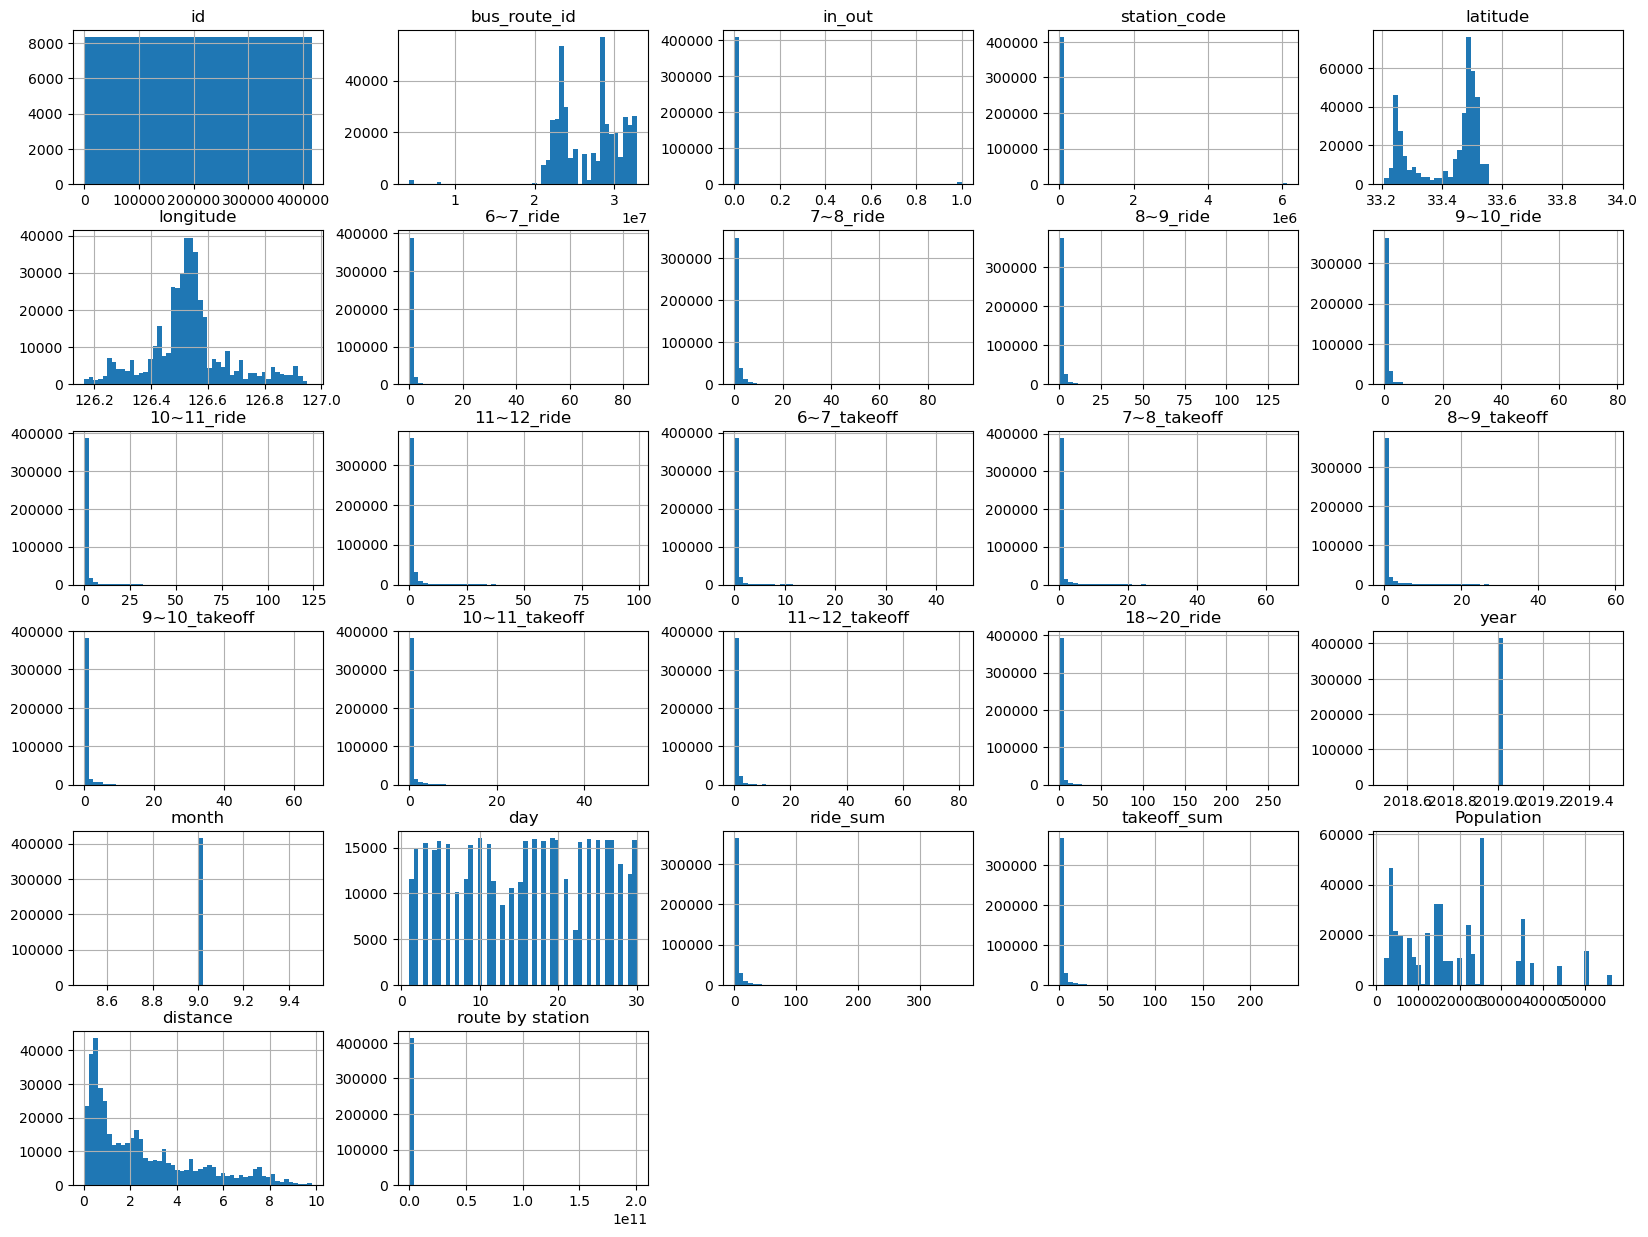

In [34]:
df_train_new.hist(bins=50, figsize=(20, 15))
plt.show()

In [35]:
X.columns

Index(['id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'year', 'month',
       'day', 'ride_sum', 'takeoff_sum', 'Population', 'distance',
       'route by station'],
      dtype='object')

In [36]:
# 전처리할 수치형데이터만 
train_num = df_train_new[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 
        'ride_sum', 'takeoff_sum', 'Population', 'distance',
       'route by station']]

In [37]:
df_train_new['8~9_ride'].value_counts() # ride, takeoff는 대부분 꼬리가 긴 형태라 표준화+로그변환

0.0      292276
1.0       58592
2.0       25365
3.0       13484
4.0        7818
          ...  
97.0          1
136.0         1
89.0          1
73.0          1
62.0          1
Name: 8~9_ride, Length: 78, dtype: int64

In [38]:
df_train_new['ride_sum'].value_counts() # 표준화 , 로그 스케일링 필요

1.0      111958
0.0      102822
2.0       56474
3.0       33775
4.0       22754
          ...  
155.0         1
148.0         1
179.0         1
149.0         1
205.0         1
Name: ride_sum, Length: 216, dtype: int64

In [39]:
df_train_new['takeoff_sum'].value_counts()# 표준화 , 로그스케일링 필요

0.0      168156
1.0      110171
2.0       47577
3.0       25677
4.0       15576
          ...  
132.0         1
165.0         1
182.0         1
141.0         1
127.0         1
Name: takeoff_sum, Length: 160, dtype: int64

In [40]:
df_train_new['Population'].value_counts() # 표준화 필요

35637    26093
25720    25633
21955    23844
3296     20602
15515    20166
3851     18754
14579    14815
50764    13521
4324     13226
12775    12529
23162    12214
7815     11940
15454    11925
25293    11748
25084    10742
19860    10660
25114    10317
5380     10240
14076     9929
17396     9660
16323     9533
34208     9518
37194     8553
12749     8168
9643      7939
43693     7356
14034     7318
3677      7147
7398      6779
5556      6486
4720      6437
9423      6091
1915      5266
8470      4963
2868      4504
56416     4089
5328      3041
4876      2007
2406       635
24301      391
2079       375
11579      269
Name: Population, dtype: int64

In [41]:
df_train_new['distance'].value_counts() # 표준화 필요

2.241564    1610
0.686223    1535
2.193293    1515
0.770852    1482
0.968183    1423
            ... 
4.642257       1
2.623033       1
2.403302       1
2.950415       1
5.342114       1
Name: distance, Length: 3563, dtype: int64

In [42]:
df_train_new['route by station'].value_counts() # 표준화, 로그 스케일링 필요

9381840.0     72
9737280.0     60
6840000.0     60
9232020.0     60
7776000.0     60
              ..
85501220.0     1
65592000.0     1
70323250.0     1
59931840.0     1
41310360.0     1
Name: route by station, Length: 29223, dtype: int64

In [43]:
# 날씨 데이터는 표준화, 정규화 둘 다 해야할 듯

In [44]:
# (1) 표준화(표준화는 전체 데이터에 다 했음.  선형회귀 모델은 표준화 필수기 때문)
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
train_num_std = std_scaler.fit_transform(train_num)
train_num_std.mean(0), train_num_std.std(0) # 컬럼별로 확인 axis=0

(array([-1.97038978e-17,  7.17002946e-17, -5.47330493e-19,  1.97038978e-17,
         6.95109726e-17, -2.29878807e-17,  3.01031771e-17,  5.30910578e-17,
         2.13458892e-17,  3.55764821e-17, -1.42305928e-17, -3.25661643e-17,
         1.20412708e-17, -5.19963968e-17, -1.86366033e-16, -8.20995740e-17,
        -1.36832623e-19]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [48]:
# # # (2) 정규화 -> 날씨 데이터만 하면 될 것 같고 여기서는 안 함
# from sklearn.preprocessing import MinMaxScaler

# min_max_scaler = MinMaxScaler()
# train_num_mm = min_max_scaler.fit_transform(train_num)
# train_num_mm.min(0), train_num_mm.max(0)

In [45]:
# 로그 스케일링 할 데이터
log_num =  df_train_new[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','ride_sum', 'takeoff_sum']]

In [46]:
# (3) 로그 스케일링 

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p)
log_train = log_transformer.fit_transform(log_num)

In [47]:
train_num.columns

Index(['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'ride_sum',
       'takeoff_sum', 'Population', 'distance', 'route by station'],
      dtype='object')

- 파이프라인

In [48]:
from sklearn.pipeline import Pipeline
log_attribs = log_num.columns

# 로그 파이프라인
log_pipeline = Pipeline([
                        ("log_transfomer", FunctionTransformer(np.log1p)),  # 로그 변환하는 변환기
                        ("std_scaler", StandardScaler())   # 표준화
                              ])

In [53]:
# # 표준화만 하는 파이프라인
# std_attribs = ['Population', 'distance', 'route by station']

# std_pipeline = Pipeline([
#                         ("std_scaler", StandardScaler())   # 표준화
#                               ])

In [49]:

from sklearn.compose import ColumnTransformer

log_attrib = log_num.columns
std_attrib = ['Population', 'distance', 'route by station']

full_pipeline = ColumnTransformer([
                                   ('log_pipeline', log_pipeline, log_attrib),  # 로그 변환하는 변환기,
                                   ('std_pipeline', StandardScaler(), std_attrib), # 표준화
                                   ('pass', 'passthrough', ['id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude','year', 'month','day'])
                                  ])

In [50]:
from sklearn import set_config
set_config(display='diagram')

In [51]:
full_pipeline

ColumnTransformer(transformers=[('log_pipeline',
                                 Pipeline(steps=[('log_transfomer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 Index(['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'ride_sum',
       'takeoff_sum'],
      dtype='object')),
                                ('std_pipeline', StandardScaler(),
                                 ['Population', 'distance',
                                  'route by station']),
                                ('pass', 'passthrough',
                                 ['id', 'bus_route_id', 'in_out',
                                  'station_code', 'latitude', 'longitude',
                                  'year', 'month', 'day'])])

In [52]:
X = df_train_new.drop('18~20_ride', axis=1)
y = df_train_new['18~20_ride']

In [53]:
X_prepared = full_pipeline.fit_transform(X) 

In [54]:
X.shape, X_prepared.shape

((415423, 26), (415423, 26))

In [97]:
preapared_columns = ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'ride_sum',
       'takeoff_sum', 'Population', 'distance', 'route by station', 'id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude','year', 'month','day']

In [98]:
preapared_columns

['6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff',
 'ride_sum',
 'takeoff_sum',
 'Population',
 'distance',
 'route by station',
 'id',
 'bus_route_id',
 'in_out',
 'station_code',
 'latitude',
 'longitude',
 'year',
 'month',
 'day']

In [88]:
pd.DataFrame(X_prepared)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.384363,0.586538,1.288376,2.818597,1.602800,3.284561,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.083350,0.0,4270000.0,1.0,344.0,33.48990,126.49373,2019.0,9.0,1.0
1,1.393273,3.097127,1.773012,2.065339,-0.488878,2.635171,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.083346,11538.0,4270000.0,1.0,344.0,33.48990,126.49373,2019.0,9.0,2.0
2,2.433124,2.116000,1.288376,3.353042,-0.488878,2.635171,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.083322,26498.0,4270000.0,1.0,344.0,33.48990,126.49373,2019.0,9.0,3.0
3,3.170910,1.743531,0.605320,1.530894,3.694478,-0.471040,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.082951,41983.0,4270000.0,1.0,344.0,33.48990,126.49373,2019.0,9.0,4.0
4,2.433124,2.116000,3.139123,-0.510066,2.150526,2.635171,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.082929,56722.0,4270000.0,1.0,344.0,33.48990,126.49373,2019.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,-0.384363,-0.570456,-0.562371,-0.510066,0.830824,-0.471040,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.080655,374291.0,20010000.0,1.0,6115044.0,33.96252,126.29429,2019.0,9.0,28.0
415419,-0.384363,-0.570456,-0.562371,-0.510066,-0.488878,-0.471040,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.079574,393524.0,27880000.0,0.0,1368.0,33.33595,126.26332,2019.0,9.0,29.0
415420,-0.384363,-0.570456,-0.562371,0.777636,-0.488878,-0.471040,-0.253869,1.295897,-0.469886,-0.43627,...,-0.077690,397921.0,31580000.0,0.0,3576.0,33.25899,126.27554,2019.0,9.0,29.0
415421,-0.384363,0.586538,-0.562371,-0.510066,-0.488878,-0.471040,-0.253869,-0.407278,-0.469886,-0.43627,...,-0.075282,400433.0,22210000.0,0.0,1585.0,33.43489,126.73242,2019.0,9.0,30.0


In [55]:
X.columns

Index(['id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'year', 'month',
       'day', 'ride_sum', 'takeoff_sum', 'Population', 'distance',
       'route by station'],
      dtype='object')

## 인구 버전 모델 분석

In [56]:
X = df_train_new.drop('18~20_ride', axis=1)
y = df_train_new['18~20_ride']

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# 선형회귀
X_train, X_valid, y_train, y_valid = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# Train a linear regression model on the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model on the validation data
lin_scores = cross_val_score(lr_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
lin_rmse = np.sqrt(-lin_scores.mean())
lin_rmse

3.8166252450457927

In [61]:
# 디시전 트리
# DecisionTree 교차검증
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse = np.sqrt(-tree_scores.mean())
tree_rmse

4.029112076912301

In [63]:
# 랜덤포레스트
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
rf_rmse = np.sqrt(-rf_scores.mean())
rf_rmse

2.797186718267071

In [64]:
# 그레디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
gbrt_reg = GradientBoostingRegressor(random_state=42)
gbrt_scores = cross_val_score(gbrt_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
gbrt_rmse = np.sqrt(-gbrt_scores.mean())
gbrt_rmse

3.214864617471431

In [ ]:
#svm 정규화 기다리고 있겠읍니다. 동심님


## 그리드 탐색

### 단순 그리드

In [77]:
from sklearn.model_selection import GridSearchCV

#rf_reg = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators' : [30, 50, 100], 'max_features' : [2, 4, 6, 8]} # 3 * 4 = 12가지 조합의 파라미터로 설정된 모델 준비

grid_search = GridSearchCV(rf_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # 3 * 4 * 5 = 60번의 학습과 검증
%time grid_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 1min 33s, sys: 1.24 s, total: 1min 34s
Wall time: 7min 34s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             scoring='neg_mean_squared_error')

In [78]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [79]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, random_state=42)

In [80]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

2.9665939449150156 {'max_features': 2, 'n_estimators': 30}
2.944093972886071 {'max_features': 2, 'n_estimators': 50}
2.9197255388716346 {'max_features': 2, 'n_estimators': 100}
2.936387916705197 {'max_features': 4, 'n_estimators': 30}
2.904208885280157 {'max_features': 4, 'n_estimators': 50}
2.8927911441667047 {'max_features': 4, 'n_estimators': 100}
2.9063173342533406 {'max_features': 6, 'n_estimators': 30}
2.882384215448393 {'max_features': 6, 'n_estimators': 50}
2.8648107872210464 {'max_features': 6, 'n_estimators': 100}
2.890224198403908 {'max_features': 8, 'n_estimators': 30}
2.859566131453767 {'max_features': 8, 'n_estimators': 50}
2.8422242431785136 {'max_features': 8, 'n_estimators': 100}


In [81]:
best_model = grid_search.best_estimator_

In [82]:
feature_importances = best_model.feature_importances_

In [83]:
len(feature_importances)

26

In [99]:
attributes = preapared_columns

In [92]:
attributes

Index(['id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride',
       '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'year', 'month',
       'day', 'ride_sum', 'takeoff_sum', 'Population', 'distance',
       'route by station'],
      dtype='object')

In [100]:
sorted(zip(feature_importances,attributes), reverse=True)

[(0.2136232652507089, 'ride_sum'),
 (0.133118970274938, '11~12_ride'),
 (0.06150005533332697, '10~11_ride'),
 (0.05008599203072162, 'longitude'),
 (0.04887396868371371, 'takeoff_sum'),
 (0.04875134834915999, 'distance'),
 (0.04813097879152662, '9~10_ride'),
 (0.04335637311716346, 'station_code'),
 (0.037914663213250675, 'bus_route_id'),
 (0.03697492603918944, 'latitude'),
 (0.03405019749892244, 'route by station'),
 (0.03362203836798733, '8~9_ride'),
 (0.029744400622142477, 'id'),
 (0.0267647840728116, 'Population'),
 (0.020902206606598944, '7~8_ride'),
 (0.02033243399127261, 'day'),
 (0.018581385344917475, '11~12_takeoff'),
 (0.017944770191826085, '8~9_takeoff'),
 (0.0165421845514822, '6~7_ride'),
 (0.016187734343732246, '9~10_takeoff'),
 (0.01597871513599977, '10~11_takeoff'),
 (0.014693223052160174, '7~8_takeoff'),
 (0.01132304435170796, '6~7_takeoff'),
 (0.0010023407847391348, 'in_out'),
 (0.0, 'year'),
 (0.0, 'month')]

### 랜덤 그리드

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators' : randint(low=1, high=200),
                  'max_features' : randint(low=1, high=8)}

rnd_search = RandomizedSearchCV(rf_reg, param_distribs, n_iter=10, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state=42)                  
rnd_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd360be9e20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd360be9d30>},
                   random_state=42, scoring='neg_mean_squared_error')

In [102]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [103]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

In [104]:
cv_results = rnd_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
      print(np.sqrt(-mean_score), params)

2.857830122897203 {'max_features': 7, 'n_estimators': 180}
2.974551792098799 {'max_features': 5, 'n_estimators': 15}
2.9322399800792778 {'max_features': 3, 'n_estimators': 72}
2.951819461049996 {'max_features': 5, 'n_estimators': 21}
2.8635814459007674 {'max_features': 7, 'n_estimators': 122}
2.9298572644201593 {'max_features': 3, 'n_estimators': 75}
2.923326101177042 {'max_features': 3, 'n_estimators': 88}
2.878337038554233 {'max_features': 5, 'n_estimators': 100}
2.9030551031919583 {'max_features': 3, 'n_estimators': 150}
3.6588967712660727 {'max_features': 5, 'n_estimators': 2}


In [105]:
best_model = grid_search.best_estimator_

In [106]:
feature_importances = best_model.feature_importances_

In [107]:
len(feature_importances)

26

In [108]:
attributes = preapared_columns

In [109]:
sorted(zip(feature_importances,attributes), reverse=True)

[(0.2136232652507089, 'ride_sum'),
 (0.133118970274938, '11~12_ride'),
 (0.06150005533332697, '10~11_ride'),
 (0.05008599203072162, 'longitude'),
 (0.04887396868371371, 'takeoff_sum'),
 (0.04875134834915999, 'distance'),
 (0.04813097879152662, '9~10_ride'),
 (0.04335637311716346, 'station_code'),
 (0.037914663213250675, 'bus_route_id'),
 (0.03697492603918944, 'latitude'),
 (0.03405019749892244, 'route by station'),
 (0.03362203836798733, '8~9_ride'),
 (0.029744400622142477, 'id'),
 (0.0267647840728116, 'Population'),
 (0.020902206606598944, '7~8_ride'),
 (0.02033243399127261, 'day'),
 (0.018581385344917475, '11~12_takeoff'),
 (0.017944770191826085, '8~9_takeoff'),
 (0.0165421845514822, '6~7_ride'),
 (0.016187734343732246, '9~10_takeoff'),
 (0.01597871513599977, '10~11_takeoff'),
 (0.014693223052160174, '7~8_takeoff'),
 (0.01132304435170796, '6~7_takeoff'),
 (0.0010023407847391348, 'in_out'),
 (0.0, 'year'),
 (0.0, 'month')]